In [1]:
# Libraries
import numpy as np   
import time
import scipy.sparse.linalg as spy
import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

warnings.filterwarnings('ignore')


def pos_def(n,x=5):
    A = np.random.rand(n,n)
    return (A+A.T) + x*np.eye(n)

alpha = 0.05

#n = 10

#for i in range(100):
#    A = pos_def(n, x = 8)
#    k = np.linalg.cond(A)
#    if k > 100 and (np.linalg.eig(A)[0] > 0).all():
#        print "Matrix selected"
#        print "Condition number: ", k
#        break
        
#x_sol = np.floor(np.random.rand(n) * 100)
#b = np.dot(A, x_sol)

In [2]:
# A better implementation of preconditioned GMRes without Cauchy integral (left)
def prec_gmres(A_0,b_0,alpha,tol=1e-6,left = True):
    it = b_0.shape[0]
    Q = np.zeros((b_0.shape[0], it+1))
    H = np.zeros((it+1,it))
    x0 = np.zeros((b_0.shape[0]))
    
    # copy
    A = np.copy(A_0)
    b = np.copy(b_0)
    M = A + alpha*np.identity(b.shape[0])
    
    # Left preconditioner -> A and b changes
    if left:
        b = gmres(M,b,tol=tol)[0]
    
    r = b - np.dot(A,x0)
    beta0 = np.linalg.norm(b)
    beta1 = np.linalg.norm(r)
    Q[:,0] = r/beta1
    
    for i in range(it):
        e = np.zeros((i+2))
        e[0] = 1
        
        if left:
            w = gmres(M, np.dot(A,Q[:,i]),tol=tol)[0]
        else:
            w = np.dot(A, gmres(M, Q[:,i],tol=tol)[0])
        
        for j in range(i+1):
            h = np.dot(Q[:,j],w)
            w -= h*Q[:,j]
            H[j,i] = h
        
        H[i+1,i] = np.linalg.norm(w)
        
        if H[i+1,i] != 0:
            Q[:,i+1] = w/H[i+1,i]
        
        y,_,_,_ = np.linalg.lstsq(H[:i+2,:i+1], beta1*e)
        residual = np.linalg.norm(np.dot(H[:i+2,:i+1],y) - beta1*e)
        
        if H[i+1,i] == 0 or residual/beta0 < tol:
            break
    
    x_tild = np.dot(Q[:,:i+1], y)
    if left:
        return x_tild, i+1
    else:
        return gmres(M, x_tild,tol=tol)[0],i+1

In [3]:
def trapezoid2(myfun, N, a, b):
    x = np.linspace(0, b, N/2) # We want N bins, so N+1 points  
    h = x[1]-x[0]
    xmiddle = x[1:-1]
    int_val = 0
    for i in xmiddle:
        int_val += 2*myfun(i).real
    int_val = 2*myfun(a).real + 2*int_val + 2*myfun(0)# + myfun(b)
    return 0.5*h*int_val

def z(t, c, r):
    return c + r*np.complex(np.cos(t), np.sin(t))

def dz(t, r):
    return r*np.complex(np.cos(t), np.sin(t))

def g(t,l,L,alpha,A, v,f, tol=1e-6):
    centro = (l + L)/2.
    radio = (L - l)/2.
    fz = f(z(t, centro, radio))
    dzz = dz(t, radio)
    p = fz*dzz
    # Separamos las matrices
    M = (centro + dzz - alpha)*np.identity(v.shape[0]) - A
    a = M.real
    b = M.imag
    al = v.real
    bet = v.imag
    
    # Construímos el nuevo sistema Hx = r
    H = np.zeros((a.shape[0]*2, a.shape[1]*2))
    H[:a.shape[0],:a.shape[1]] = a
    H[a.shape[0]:,a.shape[1]:] = a
    H[:a.shape[0],a.shape[1]:] = -b
    H[a.shape[0]:,:a.shape[1]] = b
    r = np.zeros((al.shape[0]*2))
    r[:al.shape[0]] = al
    r[al.shape[0]:] = bet
    
    sol = gmres(H,r,tol=tol)[0]
    gmr = sol[:(sol.shape[0]/2)] + 1j*sol[(sol.shape[0]/2):]
    #gmr = p*spy.gmres((centro + dzz - alpha)*np.identity(v.shape[0]) - A, v)[0]
    return p*gmr


def cauchy_integral(l, L, alpha, A, v, Nf = 50,N=128,tol=1e-6):
    #f = lambda x: (1. - (alpha/x)**(Nf+1))/(x - alpha)
    # Nueva función
    f = lambda x: (1. - (alpha/(2*x))**(Nf+1))/(x - alpha/2.)
    g1 = lambda t: g(t,l,L,alpha,A,v,f,tol=tol)
    val = trapezoid2(g1, N, -np.pi, np.pi) / (2.*np.pi)
    return val

In [4]:
# GMRes using contour integral to compute the preconditioner
def gmres(A_0, b_0, tol=1e-6, prec=False, left=True, alpha=0.0,aux_tol=1e-6):
    it = b_0.shape[0]
    Q = np.zeros((b_0.shape[0], it+1))
    H = np.zeros((it+1,it))
    x0 = np.zeros((b_0.shape[0]))
    
    A = np.copy(A_0)
    b = np.copy(b_0)
    
    if prec:
        l = alpha
        L = np.amax(np.sum(np.abs(A),axis=1))
        if left:
            b = cauchy_integral(l, L, alpha, A, b,tol=aux_tol)
    
    r = b 
    beta0 = np.linalg.norm(b)
    beta1 = np.linalg.norm(r)
    Q[:,0] = r/beta1
    
    for i in range(it):
        e = np.zeros((i+2))
        e[0] = 1
        
        if prec:
            if left:
                w = cauchy_integral(l,L,alpha,A, np.dot(A,Q[:,i]),tol=aux_tol)
            else:
                w = np.dot(A, cauchy_integral(l, L, alpha, A, Q[:,i],tol=aux_tol))
        else:
            w = np.dot(A,Q[:,i])
        
        for j in range(i+1):
            h = np.dot(Q[:,j],w)
            w -= h*Q[:,j]
            H[j,i] = h
        
        H[i+1,i] = np.linalg.norm(w)
        
        if H[i+1,i] != 0:
            Q[:,i+1] = w/H[i+1,i]
        
        y,_,_,_ = np.linalg.lstsq(H[:i+2,:i+1], beta1*e)
        residual = np.linalg.norm(np.dot(H[:i+2,:i+1],y) - beta1*e)
        
        if H[i+1,i] == 0 or residual/beta0 < tol:
            break
    
    x_tild = np.dot(Q[:,:i+1], y)
    if left or not prec:
        return x_tild,i+1
    else:
        return cauchy_integral(l, L, alpha, A, x_tild,tol=aux_tol),i+1

In [5]:
print "Exact solution:\n", x_sol
print "\nNp Solve:\n", spy.gmres(A,b)
print "\nNormal GMRes:\n", gmres(A,b)
print "\nLeft Prec NC:\n", prec_gmres(A,b,alpha)
#print "\nRight Prec NC:\n", prec_gmres(A,b,alpha,left=False)
print "\nCauchy Left Prec:\n", gmres(A, b,prec=True,alpha=alpha)
#print "\nCauchy Right Prec:\n", gmres(A,b,prec=True,left=False,alpha=alpha)

Exact solution:


NameError: name 'x_sol' is not defined

In [ ]:
all_h = []

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


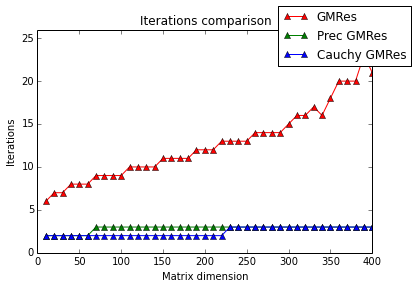

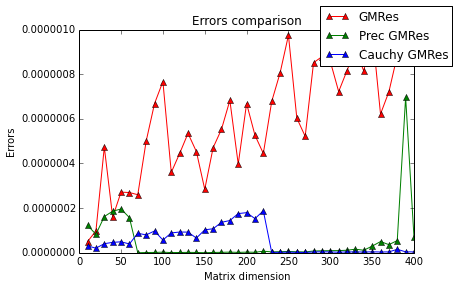

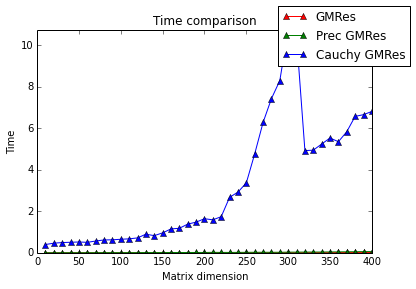

In [35]:
def graphics(n):
    it_1 = []
    it_2 = []
    it_3 = []
    er1 = []
    er2 = []
    er3 = []
    t1 = []
    t2 = []
    t3 = []
    x = range(10, n+10,10)
    for i in range(10,n+10,10):
        A = pos_def(i, x=17)
        x_sol = np.floor(np.random.rand(i) * 100)
        b = np.dot(A, x_sol)
        
        #print np.linalg.cond(A), i
        #print (np.linalg.eig(A)[0] > 0).all()
        start = time.time()
        r1 = gmres(A,b)
        t1.append(time.time() - start)
        
        start = time.time()
        r2 = prec_gmres(A,b,alpha)
        t2.append(time.time() - start)
        
        start = time.time()
        r3 = gmres(A, b,prec=True,alpha=alpha)
        t3.append(time.time() - start)
        
        it_1.append(r1[1]) 
        it_2.append(r2[1])
        it_3.append(r3[1])
        
        er1.append(np.linalg.norm(np.dot(A,r1[0]) - b)/np.linalg.norm(b))
        er2.append(np.linalg.norm(np.dot(A,r2[0]) - b)/np.linalg.norm(b))
        er3.append(np.linalg.norm(np.dot(A,r3[0]) - b)/np.linalg.norm(b))
            
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    l1, l2, l3 = ax.plot(x, it_1, 'r-^', x,it_2, 'g-^', x, it_3,'b-^')
    ax.set_xlim(0, n)
    ax.set_ylim(0, np.max(it_1)+3)
    fig.legend((l1, l2, l3), ('GMRes', 'Prec GMRes', 'Cauchy GMRes'), 'upper right')
    plt.xlabel('Matrix dimension')
    plt.ylabel('Iterations')
    plt.title('Iterations comparison')
    plt.show()
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    l1, l2, l3 = ax.plot(x, er1, 'r-^', x,er2, 'g-^', x, er3,'b-^')
    ax.set_xlim(0, n)
    ax.set_ylim(0, np.max(er1))
    fig.legend((l1, l2, l3), ('GMRes', 'Prec GMRes', 'Cauchy GMRes'), 'upper right')
    plt.xlabel('Matrix dimension')
    plt.ylabel('Errors')
    plt.title('Errors comparison')
    plt.show() 
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    l1, l2, l3 = ax.plot(x, t1, 'r-^', x,t2, 'g-^', x, t3,'b-^')
    ax.set_xlim(0, n)
    ax.set_ylim(0, np.max(t3))
    fig.legend((l1, l2, l3), ('GMRes', 'Prec GMRes', 'Cauchy GMRes'), 'upper right')
    plt.xlabel('Matrix dimension')
    plt.ylabel('Time')
    plt.title('Time comparison')
    plt.show() 
        
    return

graphics(400)
